# SNN on Icub Data

Here we implement autoencoder:

loss = loss_classification + loss_regression

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../../slayerPytorch/src")

In [2]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tas_utils import get_trainValLoader, get_testLoader

np.random.seed(1)
torch.manual_seed(1)

### upload data

In [3]:
data_dir = '../../new_data_folder/'
logDir = 'models_and_stats/'
kfold_number = 0

model_name = 'snn_classify_icub_' + str(kfold_number)
screen_fr = 20

save_dir = logDir + model_name + '.pt'

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=0)
test_loader, test_dataset = get_testLoader(data_dir)

### define spike neuron

In [9]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 75, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 75,
            },
            "tgtSpikeCount": {True: 60, False: 10},
        }
    },
}

In [5]:
class SlayerMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size1, hidden_size2, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size1)
        self.fc2 = self.slayer.dense(hidden_size1, hidden_size2)
        self.fc3 = self.slayer.dense(hidden_size2, output_size)
        
    def get_spike(self, inp):
        return self.slayer.spike(inp)
        
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc3(spike_2)))
        
        return spike_output

In [6]:
device = torch.device("cuda:1")
net = SlayerMLP(params, 60, 50, 50, 20).to(device)

In [7]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.005, weight_decay=0.5)

In [8]:
train_total_losses=[]
train_class_losses=[]

val_total_losses=[]
val_class_losses=[]

test_total_losses=[]
test_class_losses=[]

train_accs = []
test_accs = []
val_accs = []

max_val_acc = 0

for epoch in range(10001):
    net.train()
    correct = 0
    loss_train = 0
    for i, (tact, _,  target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        target = target.to(device)
        
        
        tact = net.get_spike(tact)
        # impute icub
        tact_new = torch.zeros((tact.shape[0],tact.shape[1],1,1,tact.shape[-1]*2)).to(device)
        tact_new[...,::2]  = tact
        tact = tact_new
        
        output = net.forward(tact)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        
        loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%screen_fr == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss :', 
              loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_total_losses.append(loss_train/len(train_dataset))
    
    net.eval()
    correct = 0
    loss_val = 0
    with torch.no_grad():
        for i, (tact, _, target, label) in enumerate(val_loader):

            tact = tact.to(device)
            target = target.to(device)
            
            tact = net.get_spike(tact)
            # impute icub
            tact_new = torch.zeros((tact.shape[0],tact.shape[1],1,1,tact.shape[-1]*2)).to(device)
            tact_new[...,::2]  = tact
            tact = tact_new
            
            output = net.forward(tact)
        
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)

            loss_val += loss.item()

        
    if epoch%screen_fr == 0:
        print('Val loss (all, class, reg):', 
              loss_val/len(val_dataset))
        print('Val accuracy:', correct/len(val_dataset))
    val_accs.append(correct/len(val_dataset))
    val_total_losses.append(loss_val/len(val_dataset))
    
    if correct/len(val_dataset) >= max_val_acc:
        print('Saving model at ', epoch, ' epoch')
        max_val_acc = correct/len(val_dataset)
        torch.save(net.state_dict(), save_dir)

Epoch:  0  --------------------------
Train loss : 41.068190282185874
Train accuracy: 0.21833333333333332
Val loss (all, class, reg): 33.453816452026366
Val accuracy: 0.34
Saving model at  0  epoch
Saving model at  1  epoch
Saving model at  2  epoch
Saving model at  3  epoch
Saving model at  4  epoch
Saving model at  5  epoch
Saving model at  6  epoch
Saving model at  7  epoch
Saving model at  8  epoch
Saving model at  9  epoch
Saving model at  10  epoch
Saving model at  11  epoch
Saving model at  13  epoch
Epoch:  20  --------------------------
Train loss : 13.665855623881022
Train accuracy: 0.8416666666666667
Val loss (all, class, reg): 16.26274980545044
Val accuracy: 0.745
Saving model at  25  epoch
Saving model at  26  epoch
Saving model at  33  epoch
Saving model at  34  epoch
Saving model at  37  epoch
Epoch:  40  --------------------------
Train loss : 10.223566672007243
Train accuracy: 0.88
Val loss (all, class, reg): 14.892216701507568
Val accuracy: 0.775
Saving model at  40  

Saving model at  725  epoch
Epoch:  740  --------------------------
Train loss : 3.5151388851801553
Train accuracy: 0.945
Val loss (all, class, reg): 9.009833135604858
Val accuracy: 0.86
Saving model at  748  epoch
Epoch:  760  --------------------------
Train loss : 3.488738868236542
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 9.049633359909057
Val accuracy: 0.87
Saving model at  770  epoch
Saving model at  774  epoch
Saving model at  777  epoch
Epoch:  780  --------------------------
Train loss : 3.380572244326274
Train accuracy: 0.95
Val loss (all, class, reg): 8.918383255004883
Val accuracy: 0.875
Saving model at  780  epoch
Saving model at  782  epoch
Saving model at  785  epoch
Saving model at  792  epoch
Epoch:  800  --------------------------
Train loss : 3.420144453048706
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 9.188016500473022
Val accuracy: 0.86
Saving model at  806  epoch
Epoch:  820  --------------------------
Train loss : 3.382305

Epoch:  1580  --------------------------
Train loss : 2.6501333101590476
Train accuracy: 0.95
Val loss (all, class, reg): 8.694916644096374
Val accuracy: 0.86
Epoch:  1600  --------------------------
Train loss : 2.551411120494207
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 8.251300010681152
Val accuracy: 0.865
Epoch:  1620  --------------------------
Train loss : 2.5925055241584776
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 8.216933050155639
Val accuracy: 0.86
Epoch:  1640  --------------------------
Train loss : 2.5630166494846343
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 8.219149909019471
Val accuracy: 0.87
Epoch:  1660  --------------------------
Train loss : 2.4864055065313977
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 8.380449771881104
Val accuracy: 0.845
Epoch:  1680  --------------------------
Train loss : 2.5598055112361906
Train accuracy: 0.945
Val loss (all, class, reg): 8.348999834060669
Val acc

Epoch:  2560  --------------------------
Train loss : 2.229266612728437
Train accuracy: 0.945
Val loss (all, class, reg): 8.175416369438171
Val accuracy: 0.855
Epoch:  2580  --------------------------
Train loss : 2.1826110974947612
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.997949900627137
Val accuracy: 0.86
Epoch:  2600  --------------------------
Train loss : 2.1965610164403917
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.992666605710983
Val accuracy: 0.845
Epoch:  2620  --------------------------
Train loss : 2.1969888406991958
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 8.249216346740722
Val accuracy: 0.865
Epoch:  2640  --------------------------
Train loss : 2.182827726006508
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 8.171433210372925
Val accuracy: 0.865
Epoch:  2660  --------------------------
Train loss : 2.2178444337844847
Train accuracy: 0.95
Val loss (all, class, reg): 7.902783050537109
Val ac

Epoch:  3540  --------------------------
Train loss : 2.0971999841928484
Train accuracy: 0.955
Val loss (all, class, reg): 7.519766561985016
Val accuracy: 0.855
Epoch:  3560  --------------------------
Train loss : 2.0653999442855517
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 7.695533087253571
Val accuracy: 0.865
Epoch:  3580  --------------------------
Train loss : 2.0833833078543345
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.660466480255127
Val accuracy: 0.865
Epoch:  3600  --------------------------
Train loss : 2.146255522966385
Train accuracy: 0.9433333333333334
Val loss (all, class, reg): 8.081999878883362
Val accuracy: 0.865
Epoch:  3620  --------------------------
Train loss : 2.1975110672911007
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.628733050823212
Val accuracy: 0.87
Epoch:  3640  --------------------------
Train loss : 2.1039999280373256
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 7.5271498

Epoch:  4520  --------------------------
Train loss : 2.0521944320201873
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 7.522599835395813
Val accuracy: 0.865
Epoch:  4540  --------------------------
Train loss : 2.0157721801598867
Train accuracy: 0.95
Val loss (all, class, reg): 7.80854966878891
Val accuracy: 0.865
Epoch:  4560  --------------------------
Train loss : 2.0590444003542263
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 7.231533229351044
Val accuracy: 0.87
Epoch:  4580  --------------------------
Train loss : 2.1144110947847365
Train accuracy: 0.95
Val loss (all, class, reg): 7.942166419029236
Val accuracy: 0.865
Epoch:  4600  --------------------------
Train loss : 2.0410499425729114
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.484016374349594
Val accuracy: 0.87
Epoch:  4620  --------------------------
Train loss : 2.0716276889046035
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 8.031349766254426
Val acc

Epoch:  5500  --------------------------
Train loss : 1.9764110733071962
Train accuracy: 0.95
Val loss (all, class, reg): 7.446999621391297
Val accuracy: 0.86
Epoch:  5520  --------------------------
Train loss : 1.9953666073083878
Train accuracy: 0.955
Val loss (all, class, reg): 7.409216542243957
Val accuracy: 0.86
Epoch:  5540  --------------------------
Train loss : 1.9859665921330452
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.48411658167839
Val accuracy: 0.86
Epoch:  5560  --------------------------
Train loss : 1.988277725627025
Train accuracy: 0.9566666666666667
Val loss (all, class, reg): 7.243399863243103
Val accuracy: 0.86
Epoch:  5580  --------------------------
Train loss : 1.9978721848130225
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.34394991338253
Val accuracy: 0.85
Epoch:  5600  --------------------------
Train loss : 1.9963610472281774
Train accuracy: 0.955
Val loss (all, class, reg): 7.608749866485596
Val accuracy: 0.86
Epoch

Epoch:  6480  --------------------------
Train loss : 1.9516054966052374
Train accuracy: 0.95
Val loss (all, class, reg): 7.0648000228405
Val accuracy: 0.85
Epoch:  6500  --------------------------
Train loss : 1.9495999939242998
Train accuracy: 0.95
Val loss (all, class, reg): 7.104016571044922
Val accuracy: 0.85
Epoch:  6520  --------------------------
Train loss : 1.9824388539294402
Train accuracy: 0.95
Val loss (all, class, reg): 7.136349873542786
Val accuracy: 0.855
Epoch:  6540  --------------------------
Train loss : 1.9400943844517071
Train accuracy: 0.95
Val loss (all, class, reg): 7.371066482067108
Val accuracy: 0.86
Epoch:  6560  --------------------------
Train loss : 2.01282772342364
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.303249955177307
Val accuracy: 0.86
Epoch:  6580  --------------------------
Train loss : 1.9433943438033263
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.384183294773102
Val accuracy: 0.865
Epoch:  6600  ------

Epoch:  7460  --------------------------
Train loss : 1.9758999859293302
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.331666595935822
Val accuracy: 0.86
Epoch:  7480  --------------------------
Train loss : 1.9587721915046374
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 7.098066624403
Val accuracy: 0.865
Epoch:  7500  --------------------------
Train loss : 1.9259221935768922
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 9.833816440105439
Val accuracy: 0.84
Epoch:  7520  --------------------------
Train loss : 1.9882722135881583
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 7.412249817848205
Val accuracy: 0.86
Epoch:  7540  --------------------------
Train loss : 1.952216628541549
Train accuracy: 0.95
Val loss (all, class, reg): 7.297583048343658
Val accuracy: 0.865
Epoch:  7560  --------------------------
Train loss : 1.9480610769987106
Train accuracy: 0.9566666666666667
Val loss (all, class, reg): 7.4939332711696

Epoch:  8440  --------------------------
Train loss : 1.938627706716458
Train accuracy: 0.95
Val loss (all, class, reg): 7.032033195495606
Val accuracy: 0.85
Epoch:  8460  --------------------------
Train loss : 1.9348054996629556
Train accuracy: 0.95
Val loss (all, class, reg): 7.031566449403763
Val accuracy: 0.86
Epoch:  8480  --------------------------
Train loss : 1.9429444095989068
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 7.242116403579712
Val accuracy: 0.855
Epoch:  8500  --------------------------
Train loss : 1.947755528340737
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 6.971549925804138
Val accuracy: 0.86
Epoch:  8520  --------------------------
Train loss : 1.9593944116433462
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.080649898052216
Val accuracy: 0.85
Epoch:  8540  --------------------------
Train loss : 1.9864499913156033
Train accuracy: 0.9466666666666667
Val loss (all, class, reg): 7.045649815797805
Val accura

Epoch:  9420  --------------------------
Train loss : 1.9594777192175388
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 6.962666664123535
Val accuracy: 0.855
Epoch:  9440  --------------------------
Train loss : 1.946944438368082
Train accuracy: 0.9533333333333334
Val loss (all, class, reg): 7.123016539812088
Val accuracy: 0.855
Epoch:  9460  --------------------------
Train loss : 1.9339832942684492
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 6.961833026409149
Val accuracy: 0.86
Epoch:  9480  --------------------------
Train loss : 1.9483166299760342
Train accuracy: 0.9516666666666667
Val loss (all, class, reg): 7.194166499376297
Val accuracy: 0.86
Epoch:  9500  --------------------------
Train loss : 1.9734055267771085
Train accuracy: 0.95
Val loss (all, class, reg): 7.121700010895729
Val accuracy: 0.855
Epoch:  9520  --------------------------
Train loss : 1.9412999557952086
Train accuracy: 0.9483333333333334
Val loss (all, class, reg): 7.281616647

In [14]:
# save stats
import pickle
all_stats = [
    train_total_losses,
    val_total_losses,
    train_accs,
    val_accs
]

pickle.dump(all_stats, open(logDir + model_name + '_stats.pkl', 'wb'))

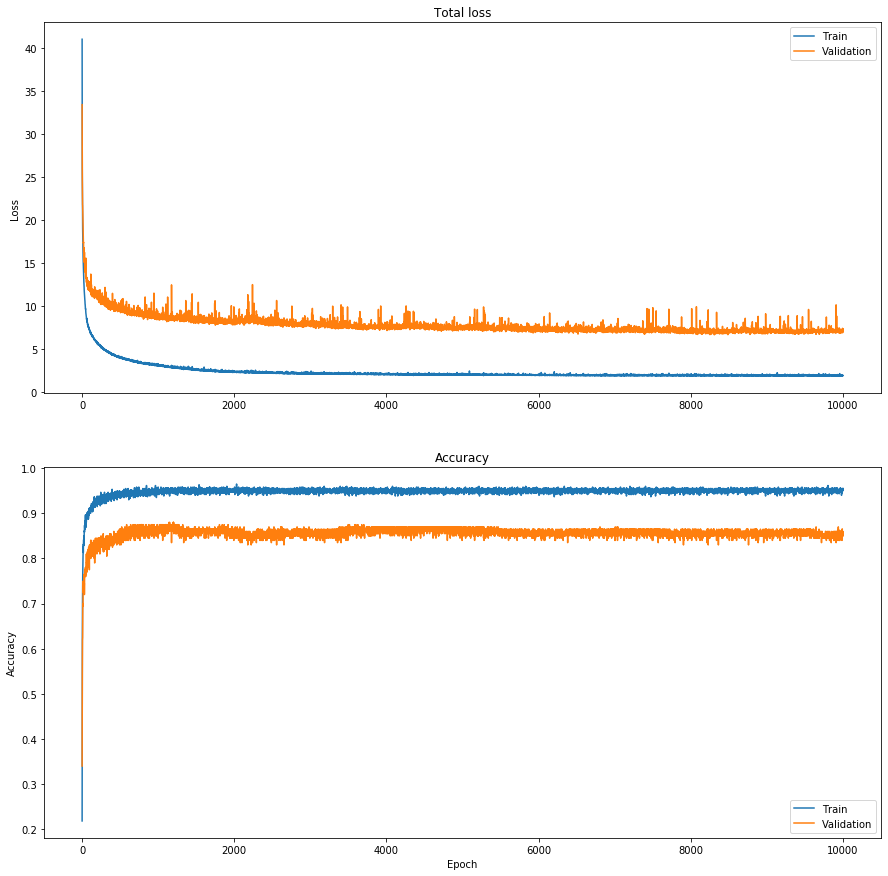

In [15]:
fig, ax = plt.subplots(2, figsize=(15,15))

ax[0].set_title('Total loss')
ax[0].plot(train_total_losses)
ax[0].plot(val_total_losses)
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Validation'])

ax[1].set_title('Accuracy')
ax[1].plot(train_accs)
ax[1].plot(val_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Validation'])

plt.show()

In [10]:
# testing set check
net_trained = SlayerMLP(params, 60, 50, 50, 20).to(device)
net_trained.load_state_dict(torch.load(save_dir))
net_trained.eval()

SlayerMLP(
  (slayer): spikeLayer()
  (fc1): _denseLayer(60, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc2): _denseLayer(50, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (fc3): _denseLayer(50, 20, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
)

In [11]:
correct = 0
loss_test = 0
with torch.no_grad():
    for i, (tact, _, target, label) in enumerate(test_loader):

        tact = tact.to(device)
        target = target.to(device)
        
        tact = net.get_spike(tact)
        # impute icub
        tact_new = torch.zeros((tact.shape[0],tact.shape[1],1,1,tact.shape[-1]*2)).to(device)
        tact_new[...,::2]  = tact
        tact = tact_new
        
        output = net_trained.forward(tact)

        correct += torch.sum(snn.predict.getClass(output) == label).data.item()

In [12]:
print(correct/len(test_loader.dataset))

0.79


In [ ]:
count = 0
testing_true = torch.zeros([len(test_loader.dataset),2])
with torch.no_grad():
    for i, (tact_icub, tact_bio,  target, label) in enumerate(test_loader, 0):
        testing_true[count:count+label.shape[0],0] = label

        # Forward pass of the network.
        tact_bio = tact_bio.to(device)
        tact_bio = tact_bio[...,::2]
        tact_bio = net.get_spike(tact_bio)
        output, _, rep_out_bio, _ = net_trained.forward(tact_bio)
        predicted_label = snn.predict.getClass(output)

        testing_true[count:count+label.shape[0],1] = predicted_label
        count += label.shape[0]
cm = confusion_matrix(testing_true[:,0].numpy(), testing_true[:,1].numpy())
plt.figure(figsize = (10,7))
plt.tight_layout(True)
sn.heatmap(cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()